In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torchvision.transforms.v2 import ToImage, Resize, CenterCrop, Compose
from transformers import CLIPProcessor, CLIPModel
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, StableUnCLIPImg2ImgPipeline

from semantic_selective_classification import semantic_binning
from utils import ECE_calc

path_huggingface = os.path.expandvars('$DSDIR/HuggingFace_Models/') 
path_pretrained = Path(os.path.expandvars('$WORK/MODELS'))
path_sd = path_pretrained / 'stabilityai--stable-diffusion-2-1-base'


In [2]:
class CLIP_ZeroShot(nn.Module):
    def __init__(self, list_prompts):
        super().__init__()
        self.CLIP_model = CLIPModel.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14").cuda()
        self.CLIP_processor = CLIPProcessor.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14")
        self.list_prompts = list_prompts

    def forward(self, images):
        with torch.no_grad():
            inputs = self.CLIP_processor(text=self.list_prompts, images=images, return_tensors="pt", padding=True)
            for name, tensor in inputs.items():
                inputs[name] = tensor.cuda()
            outputs = self.CLIP_model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        # probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        return logits_per_image

class CUB(Dataset):
    """from https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py"""
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])
        self.class_names = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'classes.txt'), 
                                       usecols=[1], sep='.', header=None, dtype=str).iloc[:,0].str.replace('_', ' ').to_dict()

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [3]:
batch_size = 256

train_dataset = CUB(root=os.path.expandvars('$SCRATCH'), transform=Compose([ToImage(), Resize(224), CenterCrop(224)]), train=True)
test_dataset = CUB(root=os.path.expandvars('$SCRATCH'), transform=Compose([ToImage(), Resize(224), CenterCrop(224)]), train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

clip = CLIP_ZeroShot([f"A photo of a {class_name}." for class_name in list(test_dataset.class_names.values())])

attributes = {
    'background': ['in plants', 'on a branch', 'on the ground', 'on the water', 'in the sky'],
    'position': ['still', 'flying', 'swimming'],
    # 'color'
}
clip_background = CLIP_ZeroShot([f'A photo of a bird {a}.' for a in attributes["background"]])
clip_position = CLIP_ZeroShot([f'The bird is {a}.' for a in attributes["position"]])

In [4]:
fname = '../results/logs_CLIP.csv'

if os.path.exists(fname):
    df = pd.read_csv(fname)
else:
    df = pd.DataFrame(index=range(len(train_dataset)+len(test_dataset)), columns=['split', 'label', 'prediction', 'correct', 'max_logit', 'max_cosim', 'max_probability', 'background_pred', 'position_pred'])
    idx = 0
    for split, dataloader in zip(['train', 'test'], [train_dataloader, test_dataloader]):
        for images, labels in dataloader:
            b_size = labels.shape[0]
            logits = clip(images).cpu()
            max_logits, predicted = logits.max(dim=1)
            max_probas = logits.softmax(dim=1).max(dim=1).values
            max_probas_2nd = torch.topk(logits.softmax(dim=1), k=2, dim=1).values[:,1]
            max_probas_3rd = torch.topk(logits.softmax(dim=1), k=3, dim=1).values[:,2]
            # background
            logits = clip_background(images).cpu()
            max_probas_back, predicted_back = logits.softmax(dim=1).max(dim=1)
            # position
            logits = clip_position(images).cpu()
            max_probas_pos, predicted_pos = logits.softmax(dim=1).max(dim=1)

            df.loc[idx:idx+b_size-1, 'split'] = split
            df.loc[idx:idx+b_size-1, 'label'] = labels.tolist()
            df.loc[idx:idx+b_size-1, 'prediction'] = predicted.tolist()
            df.loc[idx:idx+b_size-1, 'correct'] = (labels == predicted).tolist()
            df.loc[idx:idx+b_size-1, 'max_logit'] = max_logits.tolist()
            df.loc[idx:idx+b_size-1, 'max_cosim'] = (max_logits / clip.CLIP_model.logit_scale.exp().item()).tolist()
            df.loc[idx:idx+b_size-1, 'max_probability'] = max_probas.tolist()
            df.loc[idx:idx+b_size-1, 'max_probability_2nd'] = max_probas_2nd.tolist()
            df.loc[idx:idx+b_size-1, 'max_probability_3rd'] = max_probas_3rd.tolist()
            df.loc[idx:idx+b_size-1, 'background_pred'] = [attributes["background"][p] for p in predicted_back]
            df.loc[idx:idx+b_size-1, 'background_proba'] = max_probas_back.tolist()
            df.loc[idx:idx+b_size-1, 'position_pred'] = [attributes["position"][p] for p in predicted_pos]
            df.loc[idx:idx+b_size-1, 'position_proba'] = max_probas_pos.tolist()
            idx += b_size

    df.to_csv(fname, index=False)

 # value 'unknown' when proba is low
df.loc[df['background_proba'] < 0.6, 'background_pred'] = 'unknown'
df.loc[df['position_proba'] < 0.7, 'position_pred'] = 'unknown'

df_calib = df[df['split'] == 'train']
df_test = df[df['split'] == 'test']

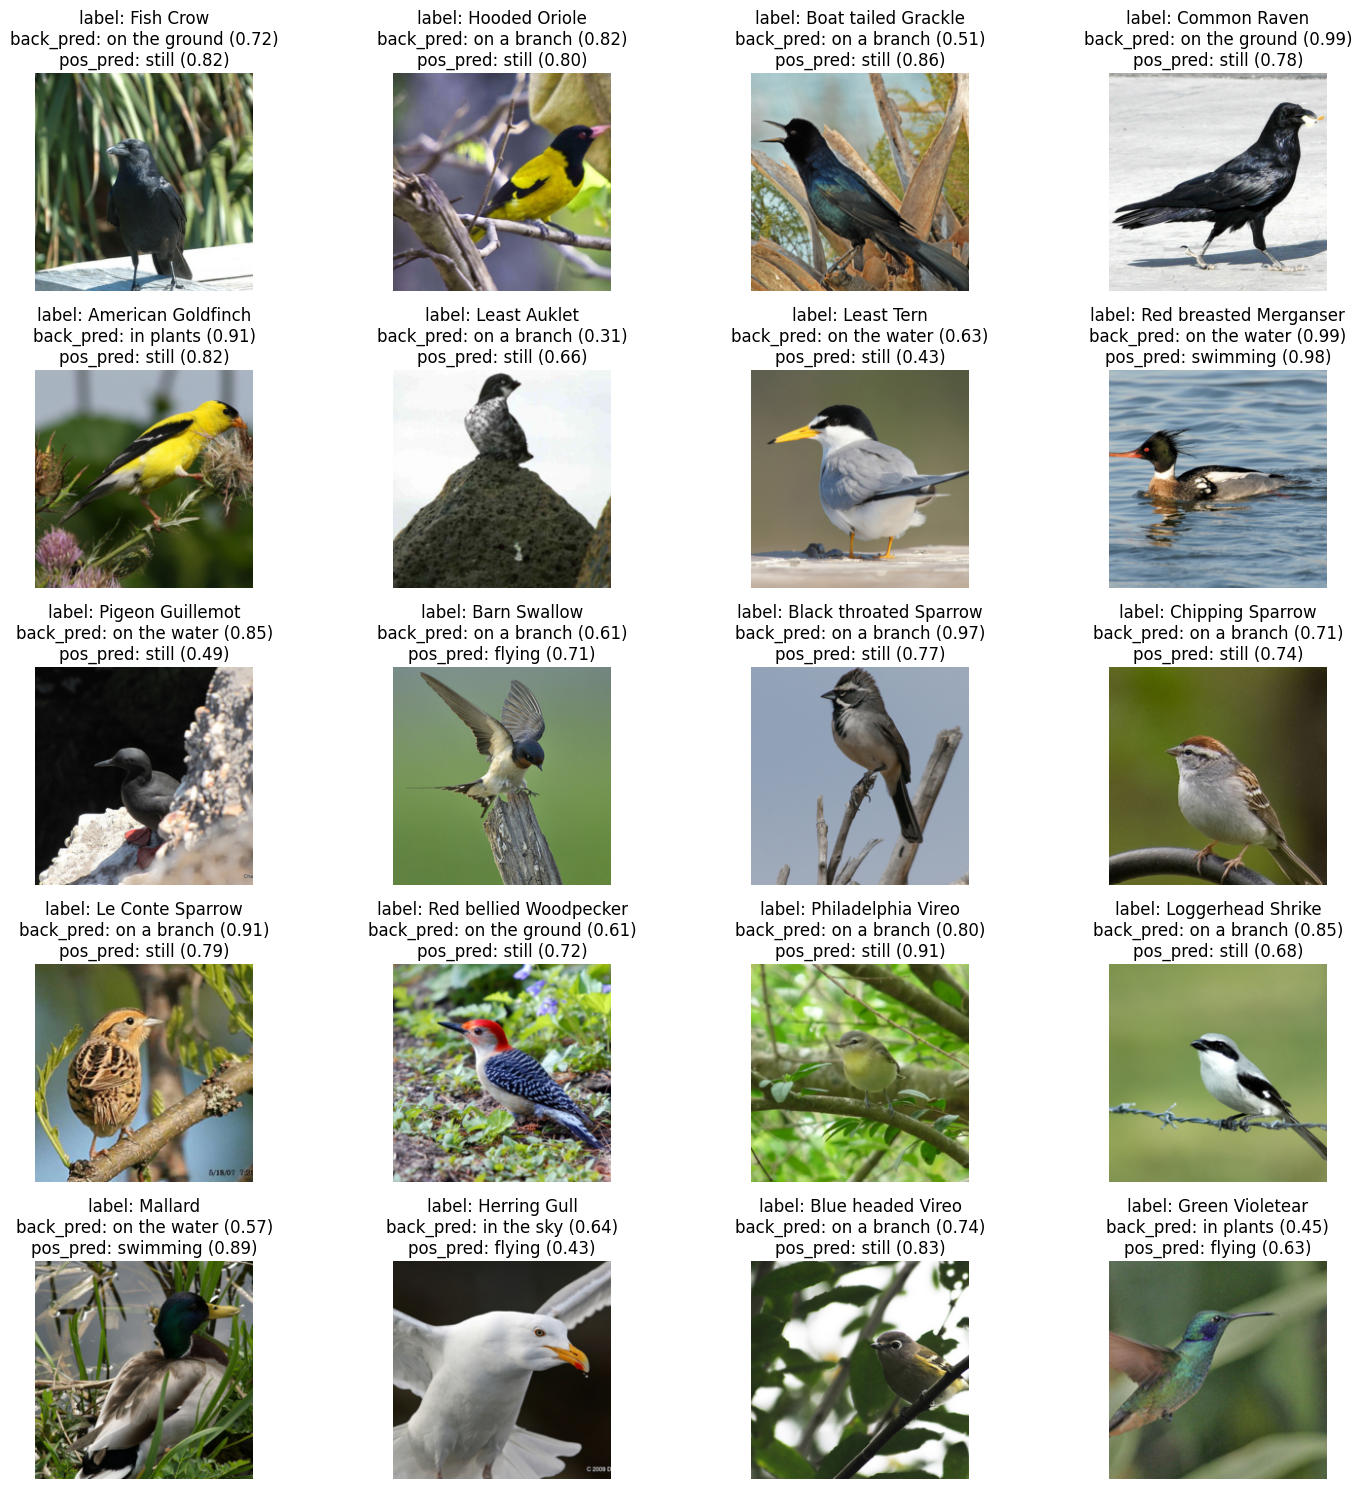

In [5]:
fig, axs = plt.subplots(5, 4, figsize=(15, 15))  # 5 rows, 4 columns

for i in range(20):
    random_index = np.random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_index]
    logit = clip_background(image).cpu()
    proba_back, predicted_back = logit.softmax(dim=1).max(dim=1)
    logit = clip_position(image).cpu()
    proba_pos, predicted_pos = logit.softmax(dim=1).max(dim=1)
    ax = axs[i // 4, i % 4]  # Determine the row and column
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f'label: {test_dataset.class_names[label]}\nback_pred: {attributes["background"][predicted_back]} ({proba_back.item():.2f})\npos_pred: {attributes["position"][predicted_pos]} ({proba_pos.item():.2f})')
    ax.axis('off')

plt.tight_layout()
plt.show()

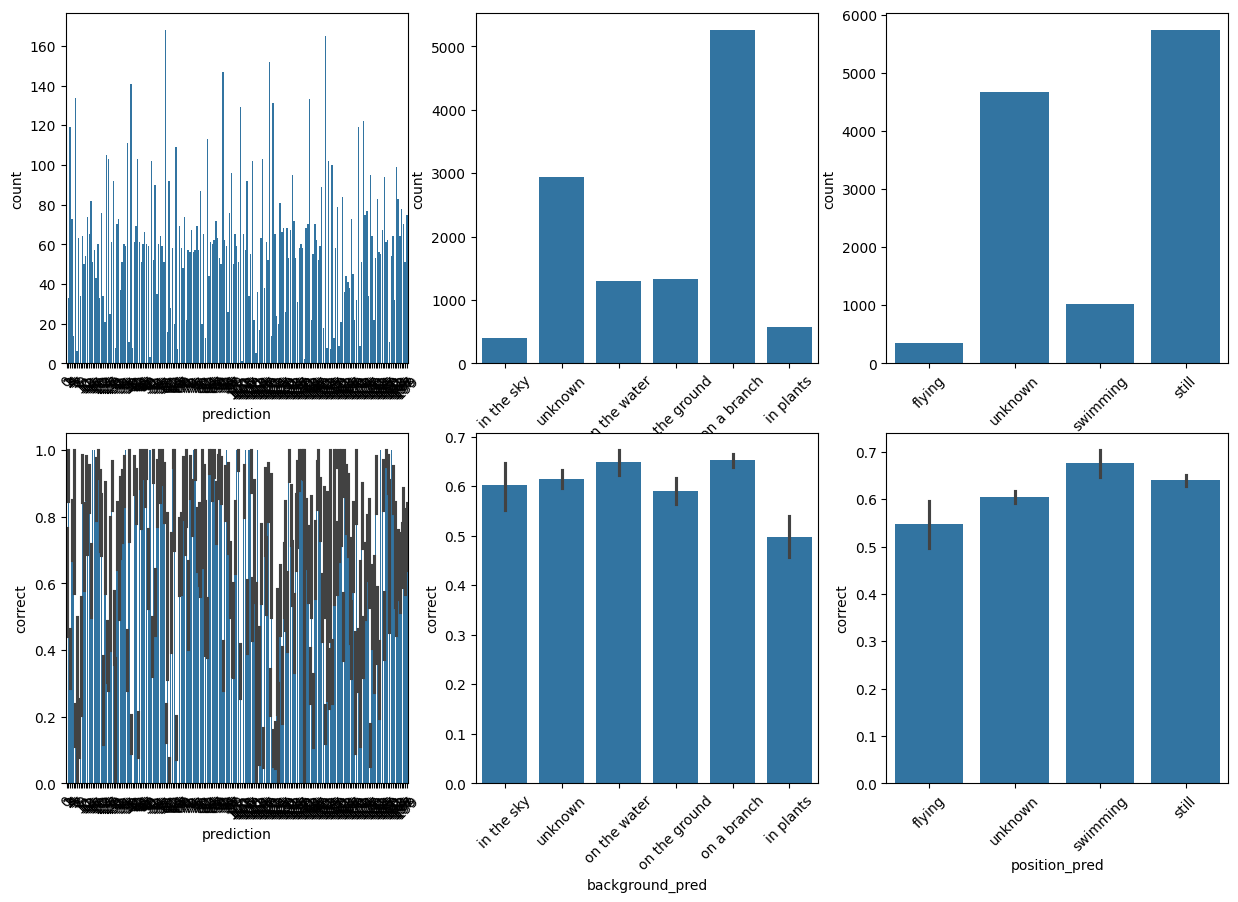

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, attribute in enumerate(['prediction', 'background_pred', 'position_pred']):
    sns.countplot(df, x=attribute, ax=axs[0, i])
    axs[0, i].tick_params(axis='x', rotation=45)
    sns.barplot(df, x=attribute, y='correct', ax=axs[1, i])
    axs[1, i].tick_params(axis='x', rotation=45)

# Uncertainty from text and image embeddings

Text(0.5, 1.0, 'class images x class images cosim')

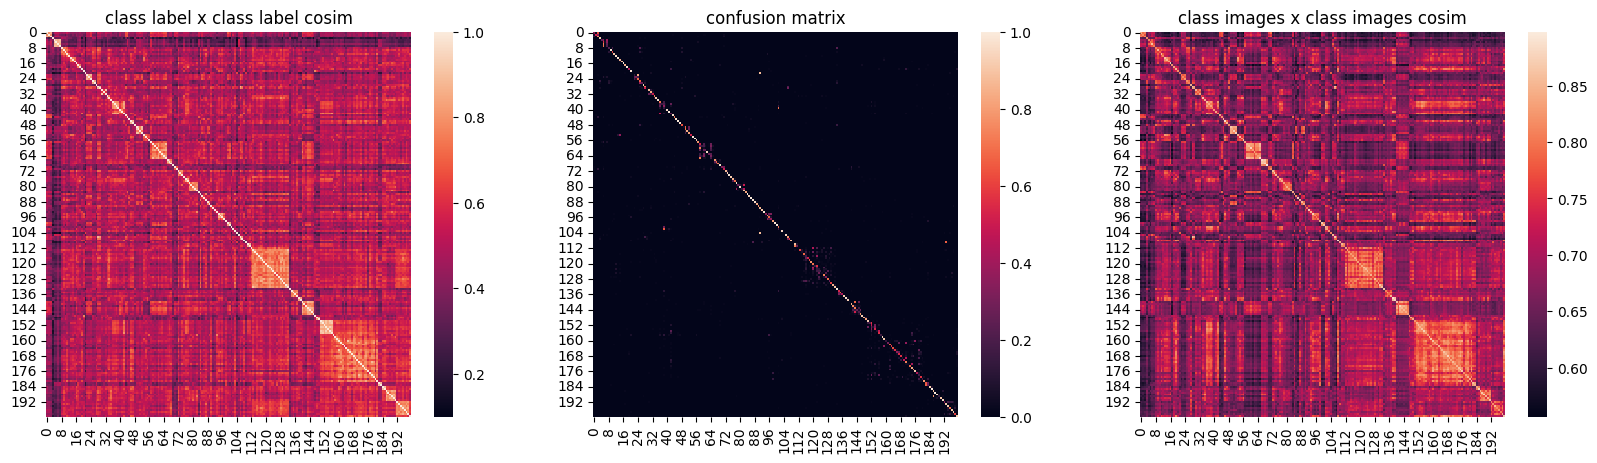

In [7]:
# study text encoder
with torch.no_grad():
    inputs = clip.CLIP_processor(text=clip.list_prompts, return_tensors="pt", padding=True)
    for name, tensor in inputs.items():
        inputs[name] = tensor.cuda()
    outputs = clip.CLIP_model.text_model(**inputs)
    text_embeds = clip.CLIP_model.text_projection(outputs[1])
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

    text_cosim = torch.matmul(text_embeds, text_embeds.t())
text_cosim = text_cosim.cpu()

# study image encoder
image_embeds_per_class = {k: [] for k in range(200)}
for dataloader in [test_dataloader]:
    for images, labels in dataloader:
        with torch.no_grad():
            inputs = clip.CLIP_processor(images=images, return_tensors="pt", padding=True)
            for name, tensor in inputs.items():
                inputs[name] = tensor.cuda()
            outputs = clip.CLIP_model.vision_model(**inputs)
            image_embeds = clip.CLIP_model.visual_projection(outputs[1])
            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        for l, i in zip(labels, image_embeds):
            image_embeds_per_class[l.item()].append(i.cpu())
image_embeds_per_class_avg = []
for k in image_embeds_per_class.keys():
    image_embeds_per_class_avg.append(torch.stack(image_embeds_per_class[k]).mean(dim=0))
image_embeds_per_class_avg = torch.stack(image_embeds_per_class_avg) 
image_cosim = torch.matmul(image_embeds_per_class_avg, image_embeds_per_class_avg.t())


# confusion matrix
cm = confusion_matrix(df['label'], df['prediction'], normalize='true')


# plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(text_cosim, ax=ax1)
ax1.set_title('class label x class label cosim')
sns.heatmap(cm, ax=ax2)
ax2.set_title('confusion matrix')
sns.heatmap(image_cosim, ax=ax3)
ax3.set_title('class images x class images cosim')


Text(0.5, 1.0, 'Corr: 0.43')

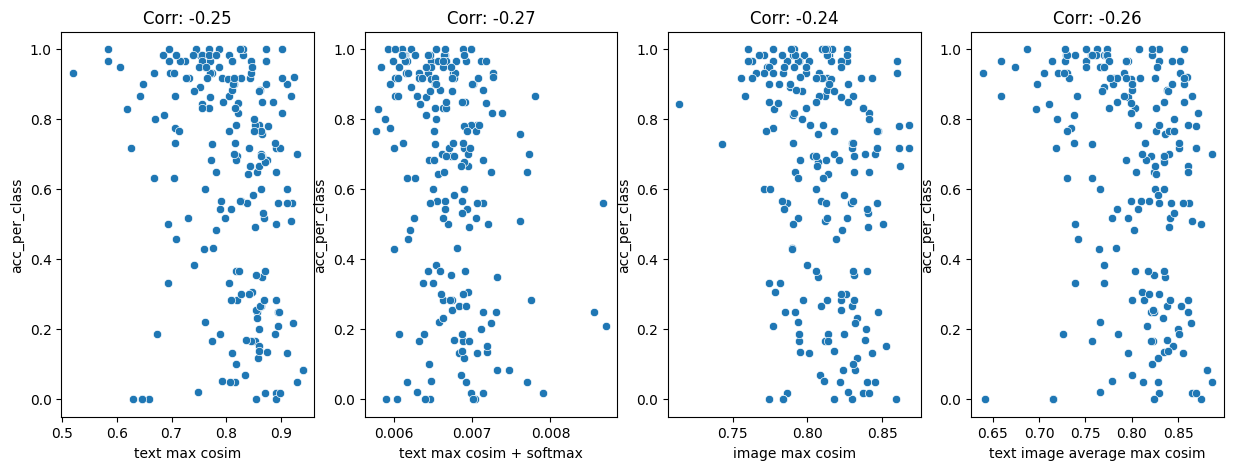

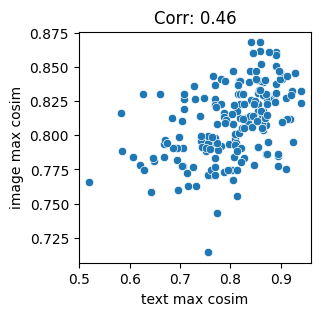

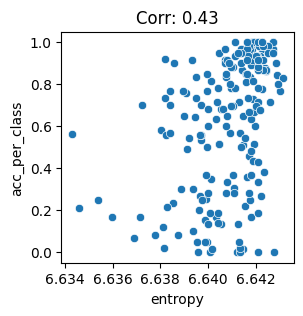

In [8]:
variables = {
    'text max cosim': torch.topk(text_cosim, k=2, dim=1).values[:,1].numpy(),
    'text max cosim + softmax': torch.topk(text_cosim.softmax(1), k=2, dim=1).values[:,1].numpy(),
    'image max cosim': torch.topk(image_cosim, k=2, dim=1).values[:,1].numpy(),
    'text image average max cosim': torch.topk(0.5*(text_cosim+image_cosim), k=2, dim=1).values[:,1].numpy(),
}
acc_per_class = df[['label', 'correct']].groupby(by=['label']).mean()['correct'].to_numpy()

fig, axs = plt.subplots(1, len(variables), figsize=(15, 5))
for (name, variable), ax in zip(variables.items(), axs.flatten()):

    sns.scatterplot(x=variable, y=acc_per_class, ax=ax)
    ax.set_ylabel('acc_per_class')
    ax.set_xlabel(name)
    ax.set_title(f'Corr: {np.corrcoef(variable, acc_per_class)[0,1]:.2f}')


plt.figure(figsize=(3, 3))
sns.scatterplot(x=torch.topk(text_cosim, k=2, dim=1).values[:,1].numpy(), y=torch.topk(image_cosim, k=2, dim=1).values[:,1].numpy())
plt.xlabel('text max cosim')
plt.ylabel('image max cosim')
plt.title(f'Corr: {np.corrcoef(torch.topk(text_cosim, k=2, dim=1).values[:,1].numpy(), torch.topk(image_cosim, k=2, dim=1).values[:,1].numpy())[0,1]:.2f}')


entropy = []
for i in range(200):
    vec = text_cosim[i]
    vec = torch.cat((vec[:i], vec[i+1:])) # remove self similarity
    vec = torch.topk(vec, k=100).values
    # vec = clip.CLIP_model.logit_scale.exp().detach().cpu() * vec
    probas = vec.softmax(0)
    entropy.append(-(probas * torch.log2(probas)).sum())
variable = np.array(entropy)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(x=variable, y=acc_per_class, ax=ax)
ax.set_ylabel('acc_per_class')
ax.set_xlabel('entropy')
ax.set_title(f'Corr: {np.corrcoef(variable, acc_per_class)[0,1]:.2f}')


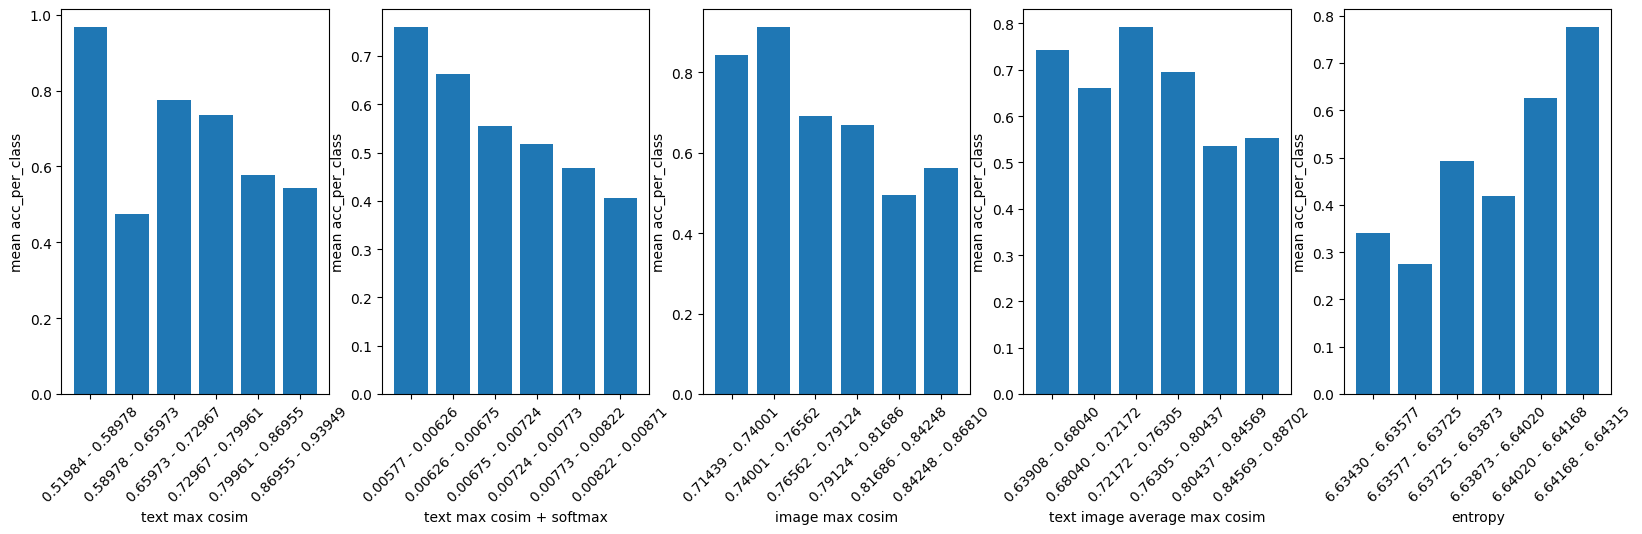

In [10]:
n_bins = 6
variables = {
    'text max cosim': torch.topk(text_cosim, k=2, dim=1).values[:,1].numpy(),
    'text max cosim + softmax': torch.topk(text_cosim.softmax(1), k=2, dim=1).values[:,1].numpy(),
    # 'text max cosim diagfree + softmax': torch.topk(text_cosim_diagfree.softmax(1), k=1, dim=1).values[:,0].numpy(),
    'image max cosim': torch.topk(image_cosim, k=2, dim=1).values[:,1].numpy(),
    'text image average max cosim': torch.topk(0.5*(text_cosim+image_cosim), k=2, dim=1).values[:,1].numpy(),
    'entropy': np.array(entropy)
}

fig, axs = plt.subplots(1, len(variables), figsize=(20, 5))
for (name, variable), ax in zip(variables.items(), axs.flatten()):

    bins = np.linspace(min(variable), max(variable), n_bins+1)
    binned_indices = np.digitize(variable, bins)
    average_accuracies = []
    for i in range(1, n_bins+1):
        # Find accuracies in the current bin
        accuracies_in_bin = np.array(acc_per_class)[binned_indices == i]
        # Compute average accuracy
        average_accuracy = np.mean(accuracies_in_bin) if accuracies_in_bin.size > 0 else None
        average_accuracies.append(average_accuracy)
    average_accuracies = [0 if acc is None else acc for acc in average_accuracies]
    ax.bar([f"{bins[i]:.5f} - {bins[i+1]:.5f}" for i in range(n_bins)], average_accuracies)
    ax.set_ylabel('mean acc_per_class')
    ax.set_xlabel(name)
    ax.tick_params(axis='x', rotation=45)

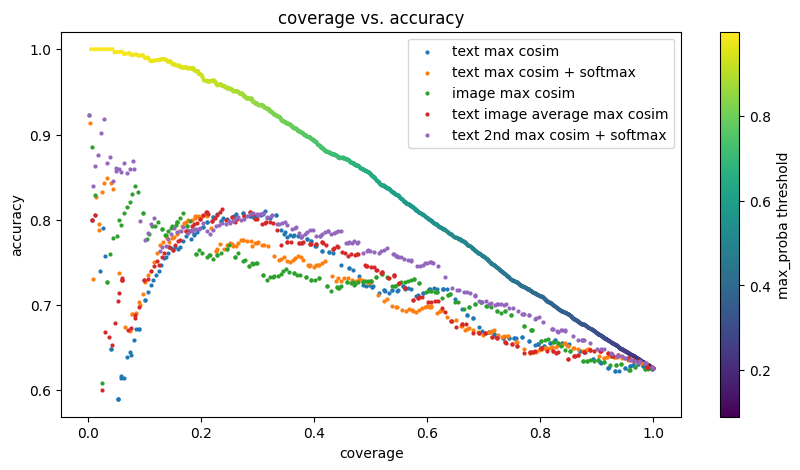

In [11]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(df_test['max_probability'].min(), df_test['max_probability'].max(), 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['max_probability'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test.loc[idx_domain, 'correct'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, s=4, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='max_proba threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

variables = {
    'text max cosim': torch.topk(text_cosim, k=2, dim=1).values[:,1].numpy(),
    'text max cosim + softmax': torch.topk(text_cosim.softmax(1), k=2, dim=1).values[:,1].numpy(),
    'image max cosim': torch.topk(image_cosim, k=2, dim=1).values[:,1].numpy(),
    'text image average max cosim': torch.topk(0.5*(text_cosim+image_cosim), k=2, dim=1).values[:,1].numpy(),
    'text 2nd max cosim + softmax': torch.topk(text_cosim.softmax(1), k=3, dim=1).values[:,2].numpy(),
}
for name, variable in variables.items():

    confidence_score_per_class = {}
    for i, v in enumerate(variable):
        confidence_score_per_class[i] = - v

    coverage = np.zeros(len(confidence_score_per_class))
    accuracy = np.zeros(len(confidence_score_per_class))
    for i, cut in enumerate(sorted(confidence_score_per_class.values(), reverse=True)):
        idx_domain = df_test['prediction'].replace(confidence_score_per_class) >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=name)
plt.legend()